In [17]:
!pip install transformers torch pillow numpy tqdm


In [18]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch, os, json, random
import numpy as np
from google.colab import files
from tqdm import tqdm
from datetime import date
from IPython.display import display

# Load model
MODEL_NAME = "patrickjohncyh/fashion-clip"
print("Loading model:", MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model.eval()


Loading model: patrickjohncyh/fashion-clip


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [19]:
print("Upload your TOPS:")
tops_uploaded = files.upload()
print("uploded..!")

print("Upload your BOTTOMS:")
bottoms_uploaded = files.upload()
print("uploded..!")

# Save images to folders
os.makedirs("tops", exist_ok=True)
os.makedirs("bottoms", exist_ok=True)

for name, data in tops_uploaded.items():
    with open(f"tops/{name}", "wb") as f:
        f.write(data)

for name, data in bottoms_uploaded.items():
    with open(f"bottoms/{name}", "wb") as f:
        f.write(data)


Upload your TOPS:


Saving Screenshot 2025-10-01 215751.png to Screenshot 2025-10-01 215751 (2).png
Saving Screenshot 2025-10-02 183337.png to Screenshot 2025-10-02 183337 (2).png
Saving Screenshot 2025-10-02 183433.png to Screenshot 2025-10-02 183433 (2).png
Saving Screenshot 2025-10-02 183510.png to Screenshot 2025-10-02 183510 (2).png
uploded..!
Upload your BOTTOMS:


Saving Screenshot 2025-10-05 000324.png to Screenshot 2025-10-05 000324 (2).png
Saving Screenshot 2025-10-05 000353.png to Screenshot 2025-10-05 000353 (2).png
Saving Screenshot 2025-10-05 000427.png to Screenshot 2025-10-05 000427 (2).png
Saving Screenshot 2025-10-05 000444.png to Screenshot 2025-10-05 000444 (2).png
uploded..!


In [20]:
def get_embeddings(folder):
    embs, names = [], []
    for fname in tqdm(os.listdir(folder)):
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("RGB")
        inputs = processor(images=img, return_tensors="pt")
        with torch.no_grad():
            emb = model.get_image_features(**inputs)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        embs.append(emb)
        names.append(fname)
    return torch.cat(embs), names

top_embs, top_names = get_embeddings("tops")
bot_embs, bot_names = get_embeddings("bottoms")
print(f"✅ Extracted {len(top_names)} tops and {len(bot_names)} bottoms")


100%|██████████| 12/12 [00:04<00:00,  2.83it/s]

✅ Extracted 13 tops and 12 bottoms


👗 Outfit suggestions for 2025-10-05:

Screenshot 2025-10-02 183625.png + Screenshot 2025-10-05 000353 (2).png  →  score 0.606


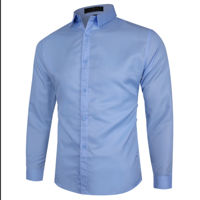

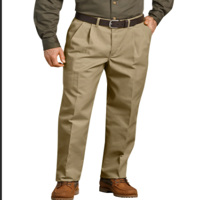

Screenshot 2025-10-02 183625.png + Screenshot 2025-10-05 000427 (2).png  →  score 0.598


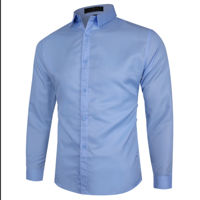

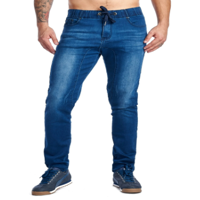

Screenshot 2025-10-02 183433 (1).png + Screenshot 2025-10-05 000444 (2).png  →  score 0.577


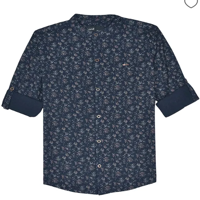

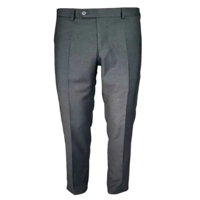

In [21]:
def suggest_outfits(num=3):
    # Load or create history file
    history_path = "usage_history.json"
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            used = json.load(f)
    else:
        used = []

    sim = top_embs @ bot_embs.T
    suggestions = []
    for _ in range(num):
        best_score = -1
        best_pair = None
        for i, top in enumerate(top_names):
            for j, bot in enumerate(bot_names):
                pair = f"{top}+{bot}"
                if pair in used:  # skip already used combos
                    continue
                score = float(sim[i, j])
                if score > best_score:
                    best_score = score
                    best_pair = (top, bot, score)
        if best_pair:
            suggestions.append(best_pair)
            used.append(f"{best_pair[0]}+{best_pair[1]}")

    # Save updated history
    with open(history_path, "w") as f:
        json.dump(used, f)

    # Show suggestions
    print(f"👗 Outfit suggestions for {date.today()}:\n")
    for t, b, s in suggestions:
        print(f"{t} + {b}  →  score {s:.3f}")
        display(Image.open(f"tops/{t}").resize((200,200)))
        display(Image.open(f"bottoms/{b}").resize((200,200)))

suggest_outfits(3)
